In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# COVID Dashboard

Analysis of current COVID 19 new case data from multiple sources

Loading CSSE County CSV data...
(3342, 762)
Loading US population data...
(3094, 6)


SelectMultiple(description='US Counties', index=(1745, 1795, 1772, 1815), options=('Autauga, Alabama, US', 'Ba…

Output()

Button(description='Replot', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>


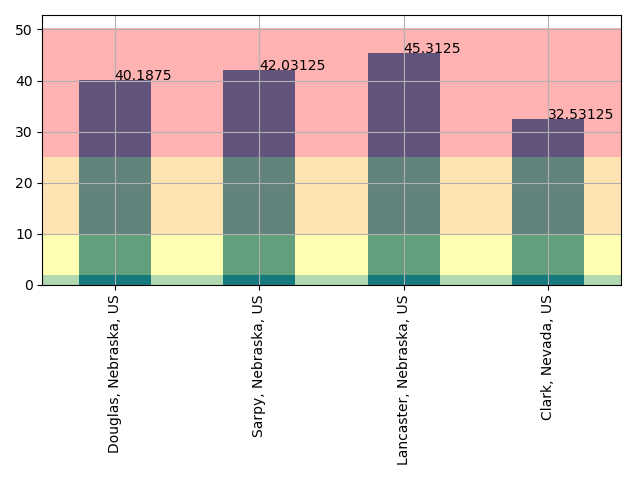

<IPython.core.display.Javascript object>


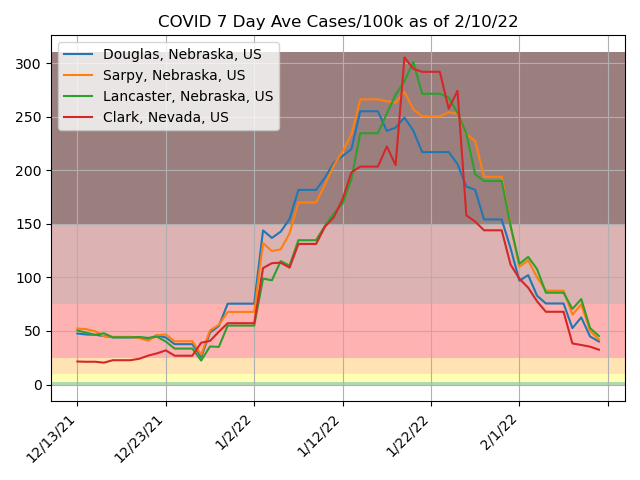

fixing pop FIPS Code format...
fixing case FIPS format...
Merging Case and Population data...
Index(['County', 'State', 'FIPS Code', 'Population', 'Area', 'Density', 'UID',
       'iso2', 'iso3', 'code3',
       ...
       '2/1/22', '2/2/22', '2/3/22', '2/4/22', '2/5/22', '2/6/22', '2/7/22',
       '2/8/22', '2/9/22', '2/10/22'],
      dtype='object', length=767)
(3103, 767)
Calulating normalized ave new cases...
(3103, 752)
merge_and_calculate_full_new_cases() completed: 6.203905344009399
in get_latest_csse_county_values()
County: Douglas, Nebraska, US
Douglas:Nebraska
FIPS: 31055.0 <class 'numpy.float64'>
calculating normalized rolling average
County: Sarpy, Nebraska, US
Sarpy:Nebraska
FIPS: 31153.0 <class 'numpy.float64'>
calculating normalized rolling average
County: Lancaster, Nebraska, US
Lancaster:Nebraska
FIPS: 31109.0 <class 'numpy.float64'>
calculating normalized rolling average
County: Clark, Nevada, US
Clark:Nevada
FIPS: 32003.0 <class 'numpy.float64'>
calculating normalize

<IPython.core.display.Javascript object>


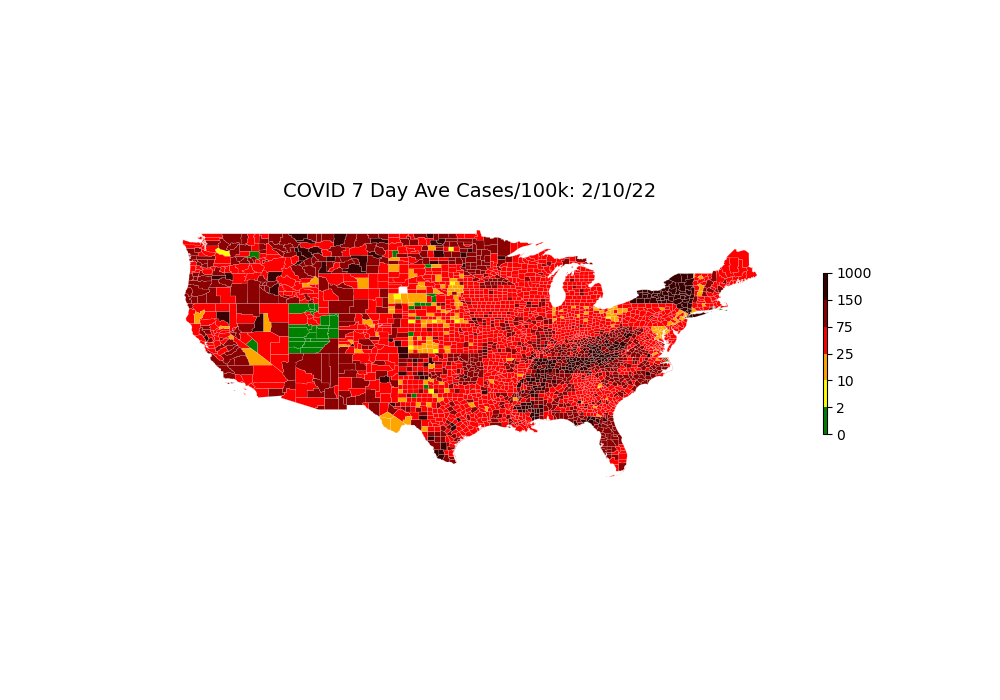

C:\Users\phild\anaconda3\envs\geo_env\lib\site-packages\geoplot\geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


Saving to 2-10-22.jpg
current_date:  2022-02-10 00:00:00


interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 740), layout=Layout(width='500px'), …

Button(description='Build GIF', style=ButtonStyle())

ipywidgets.widgets.widget_output.Output

In [57]:
#Load online county csv data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os
import time
import matplotlib.colors as colors
import matplotlib.cm as cm
#mapping
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
#imaging
import glob
from PIL import Image

csse_us_county_cases_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv';

county_pop_url = 'https://raw.githubusercontent.com/balsama/us_counties_data/main/data/counties.csv'

print("Loading CSSE County CSV data...")

csse_plot_days = 60

current_date = ''
 
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

csse_county_df = pd.read_csv(csse_us_county_cases_URL, parse_dates=True)
print(csse_county_df.shape)
#print(csse_county_df.dtypes)
#print(csse_county_df.head)

print("Loading US population data...")
county_pop_df = pd.read_csv(county_pop_url, parse_dates=True) #, usecols=['FIPS Code', 'Population'])
print(county_pop_df.shape)
#print(county_pop_df.dtypes)
#print(county_pop_df.head)

# declare global variables
# get latest csse county values
csse_current_county_values = dict()
csse_counties_norm_cases_df = pd.DataFrame()
csse_full_counties_norm_cases_df = pd.DataFrame()
csse_series_list = list() # global list of extracted county time series

# get all county values for searches
csse_county_list = csse_county_df['Combined_Key'].unique()

# populate multiple select widget with counties
output_csse_county = widgets.Output()
csse_county_select = widgets.SelectMultiple(
    options=csse_county_list.tolist(),
    name='US Counties',
    value=['Douglas, Nebraska, US', 'Sarpy, Nebraska, US', 'Lancaster, Nebraska, US', 'Clark, Nevada, US'],
    rows=15,
    description='US Counties',
    disabled=False
)
display(csse_county_select, output_csse_county)

# add plot button
output_csse_button = widgets.Output()
csse_plot_button = widgets.Button(description='Replot')
display(csse_plot_button, output_csse_button)
def csse_on_button_clicked(b):
    with output_csse_button:
        #global ave_cases_graph
        #global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        print("Selected Counties")
        print(csse_county_select.value)
        get_latest_csse_county_values(csse_county_select.value)

        print("calling - plot_current_csse_case_values")
        csse_plot_current_case_values()

        csse_extract_and_plot_time_series()
        
        #[l.remove() for l in ax.lines]
        #ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        #print("Button clicked: " +str(plot_days))

csse_plot_button.on_click(csse_on_button_clicked)


# create axes for plots and enable interactive mode if not on Google Colab
%matplotlib notebook
csse_current_cases_graph, csse_current_values_axes = plt.subplots()
csse_ave_cases_graph, csse_ave_cases_axes = plt.subplots()

#def csse_get_county_norm_new_cases(brown_excel_county_df, name, num_days):
#    #print(num_days)
#    num_days_index = -num_days
#    norm_cases_list = pd.Series(brown_excel_county_df.iloc[2,num_days_index:], name=name)
#    norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
#    #print(type(norm_cases_list))
#    #print(brown_excel_county_df.iloc[2,-2:-0])
#    #print(brown_excel_county_df.iat[2, -1])
#    #print("raw df: " +name)
#    #print(brown_excel_county_df)
#
#    return norm_cases_df

# normalize value to local cases per 100k
def pop_normalize(value, pop):
    return value * 100000/pop
    
# normalize value to local cases per 100k
def pop_normalize_internal(row):
    #pop = 
    return value * 100000/pop

def merge_and_calculate_full_new_cases():
    start = time.time()
    global csse_full_counties_norm_cases_df
    
    # convert both FIPS columns to integer
    #print_full(county_pop_df) #["FIPS Code"])
    #print("county_pop_df[FIPS Code]:" +str(county_pop_df["FIPS Code"].astype(int)))
    #print("csse_county_df[FIPS]:" +str(csse_county_df["FIPS"].astype(int)))
    print("fixing pop FIPS Code format...")
    county_pop_df["FIPS Code"] = pd.to_numeric(county_pop_df["FIPS Code"], downcast='integer', errors='coerce')
    #print(county_pop_df.head)
    print("fixing case FIPS format...")
    csse_county_df["FIPS"] = pd.to_numeric(csse_county_df["FIPS"], downcast='integer', errors='coerce')
    #print(csse_county_df.head)
    
    print("Merging Case and Population data...")
    csse_w_pop_df = county_pop_df.merge(csse_county_df, left_on='FIPS Code', right_on='FIPS').set_index('FIPS')
    print(csse_w_pop_df.columns)
    print(csse_w_pop_df.shape)
    #print(csse_w_pop_df.head)
    #print_full(csse_w_pop_df)
    #col_list = list(csse_w_pop_df)
    #print(col_list)
    
    row_list = list()
    
    print("Calulating normalized ave new cases...")
    for idx, row in csse_w_pop_df.iterrows():
        #print(idx, row['Population'], row['Combined_Key'])
        #print(row)
        county_pop = row['Population']
        county_new_cases_series = row.iloc[16:].diff().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
        #print(type(county_new_cases_series))
        #print(county_new_cases_series)
        #insert county name
        county = row['Combined_Key']
        county_new_cases_series_w_name = pd.Series({'Combined_Key':row['Combined_Key']})
        element_list = [county_new_cases_series_w_name, county_new_cases_series]
        county_new_cases_series_w_name = pd.concat(element_list, axis=0)
        #print('county_new_cases_series_w_name', type(county_new_cases_series_w_name),county_new_cases_series_w_name.shape)
        #pd.concat(pd.Series([county_name]), county_new_cases_series)
        #set series name as fips id
        county_new_cases_series_w_name.name = row['FIPS Code']
        #print(county_new_cases_series)
        row_list.append(county_new_cases_series_w_name)#county_new_cases_series)
        #csse_full_counties_norm_cases_df.append(county_new_cases_series)
    
    transposed_df = pd.concat(row_list, axis=1)
    #print(transposed_df.head)
    csse_full_counties_norm_cases_df = transposed_df.transpose()
    print(csse_full_counties_norm_cases_df.shape)
    #print(csse_full_counties_norm_cases_df.head)
    end = time.time()
    print("merge_and_calculate_full_new_cases() completed:", end-start)
    

# gets time series and latest value data from county DataFrame for a list of counties
# latest values are put in global current_county_values
# time series data is put in global counties_norm_cases
def get_latest_csse_county_values(counties_list):
    print("in get_latest_csse_county_values()")
    #current_county_values
    global csse_current_county_values
    #current_county_values.clear()
    global csse_counties_norm_cases_df
    global csse_series_list
    csse_series_list.clear()
    
    appended_data = []
    appended_current_data = dict()    
       
    for county in counties_list:
        print("County: " +str(county))
 
        # get county population
        county_loc_terms = county.split(', ')
        print(county_loc_terms[0] +':' +county_loc_terms[1])
        #county_pop = county_pop_df.query('County==county_loc_terms[0] & State==county_loc_terms[1] ')
        
        fips_code_value = csse_county_df.loc[(csse_county_df['Admin2'] == county_loc_terms[0]) & 
                                             (csse_county_df['Province_State'] == county_loc_terms[1]) ].FIPS.iat[0]
        
        print("FIPS: " +str(fips_code_value) +" " +str(type(fips_code_value)))
        
        # get all counts for selected county
        county_pop_series = county_pop_df[
            (county_pop_df.County==county_loc_terms[0] +' County') & (county_pop_df.State==county_loc_terms[1])]
            #(county_pop_df['County']==county_loc_terms[0]) & (county_pop_df['State']==county_loc_terms[1])]
        county_pop = county_pop_series.iat[0,3]

        # extract just the daily case counts from selected row
        county_counts_only_df = csse_county_df.loc[csse_county_df['Combined_Key'] == county].iloc[0, 11:]
        #print(county_counts_only_df)
        
        # get rolling average of daily difference in cases
        print("calculating normalized rolling average")
        #county_full_series = county_counts_only_df.diff().shift().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
        county_full_series = county_counts_only_df.diff().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
        #print(type(county_full_series))
        #print(county_full_series)
        
        # extract selected number of days for plot
        num_days_index = -csse_plot_days
        norm_cases_list = pd.Series(county_full_series.iloc[num_days_index:], name=county)
        norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
        #print(county_full_series.shape)
        #print(county_full_series)
        csse_series_list.append(county_full_series)
        
        
        county_latest_value = county_full_series.iat[-1]
        
        appended_current_data.update({county : county_latest_value});
        #print(county +" : " +str(county_latest_value))
        
        #county_series_slice = get_county_norm_new_cases(county_full_series, county, plot_days)
        appended_data.append(norm_cases_df)
    
    csse_current_county_values = pd.Series(appended_current_data, 
                             dtype='float16')
    print(csse_current_county_values)
    #counties_norm_cases = counties_norm_cases.iloc[0:0]
    csse_counties_norm_cases_df = pd.concat(appended_data, axis=1) #series_list)
    #print('csse_counties_norm_cases_df set type:' +str(type(csse_counties_norm_cases_df)))
    #print(csse_counties_norm_cases_df)

# define colormap for plotting
color_list = ['green', 'yellow','orange', 'red', 'darkred', '#380000']
mapping_cmap = colors.ListedColormap(color_list)
boundaries = [0, 2, 10, 25, 75, 150, 1000]
map_color_norm = colors.BoundaryNorm(boundaries, mapping_cmap.N, clip=True)
    
# set graph background colors based on cases range
def set_graph_background_color_bands(graph_axes, max_value):
    print("in set_graph_background_color_bands() max_value = " +str(max_value))
    graph_axes.axhspan(0, 2, facecolor=color_list[0], alpha=0.3)
    graph_axes.axhspan(2, 10, facecolor=color_list[1], alpha=0.3)
    graph_axes.axhspan(10, 25, facecolor=color_list[2], alpha=0.3)

    if(max_value > 150):
        graph_axes.axhspan(25, 75, facecolor=color_list[3], alpha=0.3)
        graph_axes.axhspan(75, 150, facecolor=color_list[4], alpha=0.3)
        graph_axes.axhspan(150, float(max_value)+5, facecolor=color_list[5], alpha=0.5)
    elif(max_value > 75):
        graph_axes.axhspan(25, 75, facecolor=color_list[3], alpha=0.3)
        graph_axes.axhspan(75, float(max_value)+5, facecolor=color_list[4], alpha=0.3)
    else:
        graph_axes.axhspan(25, float(max_value)+5, facecolor=color_list[3], alpha=0.3)

# plot bar graph of current case numbers
def csse_plot_current_case_values():
    print("in plot_current_csse_case_values()")
    global csse_current_county_values
    global csse_current_new_cases
    global csse_current_values_axes
    
    #csse_current_values_axes.clear()
    
    current_date = csse_county_df.columns[-1]

    #find max of current values to size graph appropriately
    cases_set_max = max(csse_current_county_values) #douglas_current, sarpy_current, lancaster_current)
    #print("max; " +str(cases_set_max))
    
    #print(csse_current_county_values)

    #current_values_axes = current_new_cases.plot(kind="bar", ax=current_values_axes)
    csse_current_values_axes = csse_current_county_values.plot(kind="bar", ax=csse_current_values_axes)
  
    # show values on bar graph
    for index, value in enumerate(csse_current_county_values):
        csse_current_values_axes.text(index, value,
             str(value))
    #print(value)
    
    csse_current_values_axes.grid()

    # add color bands for severity 
    set_graph_background_color_bands(csse_current_values_axes, cases_set_max)
    
    csse_current_cases_graph.tight_layout()
    
    plt.xticks(rotation=45, ha='right')
    #csse_current_values_axes.set_xticklabels(csse_current_values_axes.get_xticks(), rotation = 45)

   
    plt.show()
    
# extract and plot daily ave new cases / 100k
def csse_extract_and_plot_time_series():
    print('In csse_extract_and_plot_time_series()')
    global csse_ave_cases_graph
    global csse_ave_cases_axes
    global csse_counties_norm_cases_df
    
    #print("csse_counties_norm_cases_df type:" +str(type(csse_counties_norm_cases_df)))
    #print(csse_counties_norm_cases_df)
    
    current_date = csse_county_df.columns[-1]
          
    max_value = csse_counties_norm_cases_df.max().max()
    #print("Max value: ")
    #print(max_value)
    
    csse_ave_cases_axes.clear()
    csse_ave_cases_axes = csse_counties_norm_cases_df.plot(ax=csse_ave_cases_axes)
    
    csse_ave_cases_axes.set_title("COVID 7 Day Ave Cases/100k as of " +str(current_date))
    
    set_graph_background_color_bands(csse_ave_cases_axes, max_value)
    
    csse_ave_cases_axes.grid()
    
    #csse_ave_cases_axes.set_xticklabels(csse_ave_cases_axes.get_xticks(), rotation = 45)
    plt.xticks(rotation=45, ha='right')
    csse_ave_cases_graph.tight_layout()
    #plt.show()
    #print("ave_cases_graph: ")
    #print(type(ave_cases_graph))

    #counties_norm_cases.style
    
# currently not used
def calculate_full_rolling_averages_with_fips_index():
    print('in calculate_full_rolling_averages_with_fips_index()')
    global csse_county_df
    global county_pop_df
    
    # CSSE id:      'FIPS' col 4
    # pop id:       'FIPS Code' col 2
    # county polys: 'GEO_ID' col 1
    
    csse_full_county_list = csse_county_df['FIPS'].unique()
    
    for county_fips in csse_full_county_list:
    
        county_pop = county_pop_df.loc[county_pop_df['FIPS Code'] == county_fips].iat[0,3]
        
        county_counts_only_df = csse_county_df.loc[csse_county_df['fips'] == county_fips].iloc[0, 11:]
        
        print(county_fips +' pop: ' +str(county_pop))
    
        #county_norm_series = county_counts_only_df.diff().rolling(7).mean().apply(pop_normalize, args=(county_pop,))
    
def build_chloro_map():
    print('in build_chloro_map()')
    global csse_full_counties_norm_cases_df
    global mapping_cmap
    global map_color_norm
    global current_date
    
    #print(gplt.datasets)
    # Load the json file with county coordinates
    geoData_gdf = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

    # Make sure the "id" column is an integer
    geoData_gdf.id = geoData_gdf.id.astype(str).astype(int)

    # Remove Alaska, Hawaii and Puerto Rico.
    stateToRemove = ['02', '15', '72']
    geoData_gdf = geoData_gdf[~geoData_gdf.STATE.isin(stateToRemove)]
    
    #print(geoData_gdf.head)

    # Basic plot with just county outlines to test map data
    #gplt.polyplot(geoData_gdf, figsize=(10, 5), linewidth=.2)
    
    # build extracted df for given date containing id column
    current_date = csse_full_counties_norm_cases_df.columns[-1]
    #date = current_date
    print('map date: ', current_date)
    print('shape:', csse_full_counties_norm_cases_df.shape, 'columns: ', type(csse_full_counties_norm_cases_df.columns))

    # merge extracted df with geodata
    #fullData = geoData.merge(csse_full_counties_norm_cases_df, left_on=['id'], right_on=['FIPS'])
    fullData_gdf = geoData_gdf.merge(csse_full_counties_norm_cases_df, left_on=['id'], right_index=True)
    print('fullData_gdf: ', fullData_gdf.columns)
    #print(fullData_gdf)
    
    #douglas_value = fullData_gdf.loc[geoData_gdf['id'] == 31055]
    #print('Douglas, NE geo row: ')
    #print_full( douglas_value)
    
    #print(map_color_norm.__run__(0.0, clip=True))
    
    # get list of all dates from columns
    column_list = csse_full_counties_norm_cases_df.columns.to_list()
          
    # start about 10 days in to avoid NaN values from rolling average + name column
    all_dates = column_list[11:]
    #print('dates: ', all_dates)
    
    # plot chloropleth
    map_fig, map_ax = plt.subplots(1, 1, figsize=(10, 7))
    
    map_fig.colorbar(cm.ScalarMappable(norm=map_color_norm, cmap=mapping_cmap), 
        ax=map_ax, location='right', 
        aspect=40, 
        shrink=.3, 
        fraction=.1,
        pad=.01,
        anchor=(0,0.5)
    )
    
    #select dates to map
    dates = all_dates[-1:]
    
    for date in dates:
        plot_map(date, fullData_gdf, map_fig, map_ax)
    
    #build_animated_gif(dates)
    
def plot_map(date, combined_df, fig, ax):
    #fig.clear()
    ax.clear()
    scheme = mc.UserDefined(combined_df[date], boundaries)
    
    gplt.choropleth(combined_df, 
        hue=date, 
        linewidth=.1,
        scheme=scheme, 
        #projection=gcrs.AlbersEqualArea(),
        cmap=mapping_cmap,
        #norm=map_color_norm,
        legend=False,
        edgecolor='white',
        ax=ax
    )
    
    ax.set_title('COVID 7 Day Ave Cases/100k: ' +str(date), fontsize=14)
    
    fig.show()
    
    path = '../data/map-images/'
    fname = date.replace('/', '-') +'.jpg' 
    
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
    
    print('Saving to ' +fname)
    
    fig.savefig(path +fname)
    
#build animated gif of map images from sorted list of dates
def build_animated_gif(date_list):
    print('building animated gif...')
    frame_dir = '../data/map-images/'
    output_dir = '../data/'
    output_fname = output_dir +'animated-covid-map.gif'
    
    frames = []
    
    for date in date_list:
        image_fname = frame_dir +date.replace('/', '-') +'.jpg'
        frames.append(Image.open(image_fname))
        
    #frames = [Image.open(image) for image in glob.glob(f"{frame_dir}/*.JPG")]
    frame_one = frames[0]
    frame_one.save(output_fname, format="GIF", append_images=frames,
               save_all=True, duration=700, loop=0)
    print("generated file" +output_fname)

merge_and_calculate_full_new_cases()

get_latest_csse_county_values(csse_county_select.value)

print("calling - plot_current_csse_case_values")
csse_plot_current_case_values()

csse_extract_and_plot_time_series()

#calculate_full_rolling_averages_with_fips_index()

build_chloro_map()

#add interactive toolsmfor builing animated gif
from datetime import datetime

end_date = datetime.strptime(current_date, '%m/%d/%y')
start_date = datetime(2020, 2, 1)
print('current_date: ', end_date)

gif_begin_date = start_date
gif_end_date = end_date

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime('%m/%d/%y'), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider

def print_date_range(date_range):
    print(date_range)

widgets.interact(
    print_date_range,
    date_range=selection_range_slider
);

gif_out = widgets.Output

def button_selected(b):
    with gif_out:
        print('button pressed')

build_gif_button = widgets.Button(description='Build GIF')
build_gif_button.on_click=button_selected

display(build_gif_button, gif_out)


In [ ]:
%lsmagic